# [1] Deep Reinforcement Learning in a Handful of Trials using Probabilistic Dynamics Models

keywords: model-based

## Abstract

基于模型的强化学习(RL)算法可以获得良好的样本效率，但在渐近性能方面往往落后于最佳的无模型算法。 对于大容量的参数函数近似器，如深度网络，尤其如此。 本文利用**感知不确定性**动力学模型研究如何弥合这一差距。 本文提出了一种新的叫作带有轨迹采样的概率集成(probabilistic ensembles with trajectory sampling, PETS)算法，该算法将**感知不确定性深度网络动力学模型**与**基于采样的不确定传播**结合。 我们与最先进的基于模型和无模型的深度RL算法的比较表明，我们的方法在几个具有挑战性的基准任务上与无模型算法的渐近性能相匹配，而所需的样本显著减少（例如，在半猎豹任务上，所需的样本分别比SAC和PPO少8倍和125倍）。 

## 相关工作

1. Isolating epistemic uncertainty is especially useful for directing exploration [Thrun, 1992], although we leave this for future work.
2. Nagabandi et al. [2017] use deterministic NN models and MPC with random shooting to achieve data efﬁcient control in higher dimensional tasks than what is feasible for GPs to model.
3. 

## 简介

### MPC

基于值函数的方法 DQN、基于策略的方法 REINFORCE 以及两者结合的方法 Actor-Critic。它们都是无模型（model-free）的方法，即没有建立一个环境模型来帮助智能体决策。而在深度强化学习领域下，基于模型（model-based）的方法通常用神经网络学习一个环境模型，然后利用该环境模型来帮助智能体训练和决策。利用环境模型帮助智能体训练和决策的方法有很多种，例如可以用与之前的 Dyna 类似的思想生成一些数据来加入策略训练中。本章要介绍的**模型预测控制**（model predictive control，MPC）算法并不构建一个显式的策略 (只规划及优化一个动作序列)，只根据环境模型来选择当前步要采取的动作。

本文的实验中使用MPC有几个原因，包括实现简单，较低的计算负担（没有梯度），不需要预先指定任务视界，且能实现相同的数据效率. 

### 1. MPC---打靶法

首先，让我们用一个形象的比喻来帮助理解模型预测控制方法。假设我们在下围棋，现在根据棋盘的布局，我们要选择现在落子的位置。一个优秀的棋手会根据目前局势来推演落子几步可能发生的局势，然后选择局势最好的一种情况来决定当前落子位置。

模型预测控制方法就是这样一种迭代的、基于模型的控制方法。值得注意的是，MPC 方法中不存在一个显式的策略。具体而言，MPC 方法在每次采取动作时，首先会生成一些候选动作序列，然后根据当前状态来确定每一条候选序列能得到多好的结果，最终选择结果最好的那条动作序列的第一个动作来执行。因此，在使用 MPC 方法时，主要在两个过程中迭代，一是根据历史数据学习环境模型$\hat P(s, a)$，二是在和真实环境交互过程中用环境模型来选择动作。

首先，我们定义模型预测方法的目标。在第$k$步时，我们要想做的就是最大化智能体的累积奖励，具体来说就是：

$$
\underset{a_{k: k+H}}{\arg \max } \sum_{t=k}^{k+H} r\left(s_{t}, a_{t}\right) \text { s.t. } s_{t+1}=\hat{P}\left(s_{t}, a_{t}\right)
$$

其中$H$为推演的长度，$\arg \max _{a_{k: k+H}}$表示从所有动作序列中选取累积奖励最大的序列。我们每次取最优序列中的第一个动作$a_k$来与环境交互。MPC 方法中的一个关键是如何生成一些候选动作序列，候选动作生成的好坏将直接影响到 MPC 方法得到的动作。生成候选动作序列的过程我们称为打靶（shooting）。

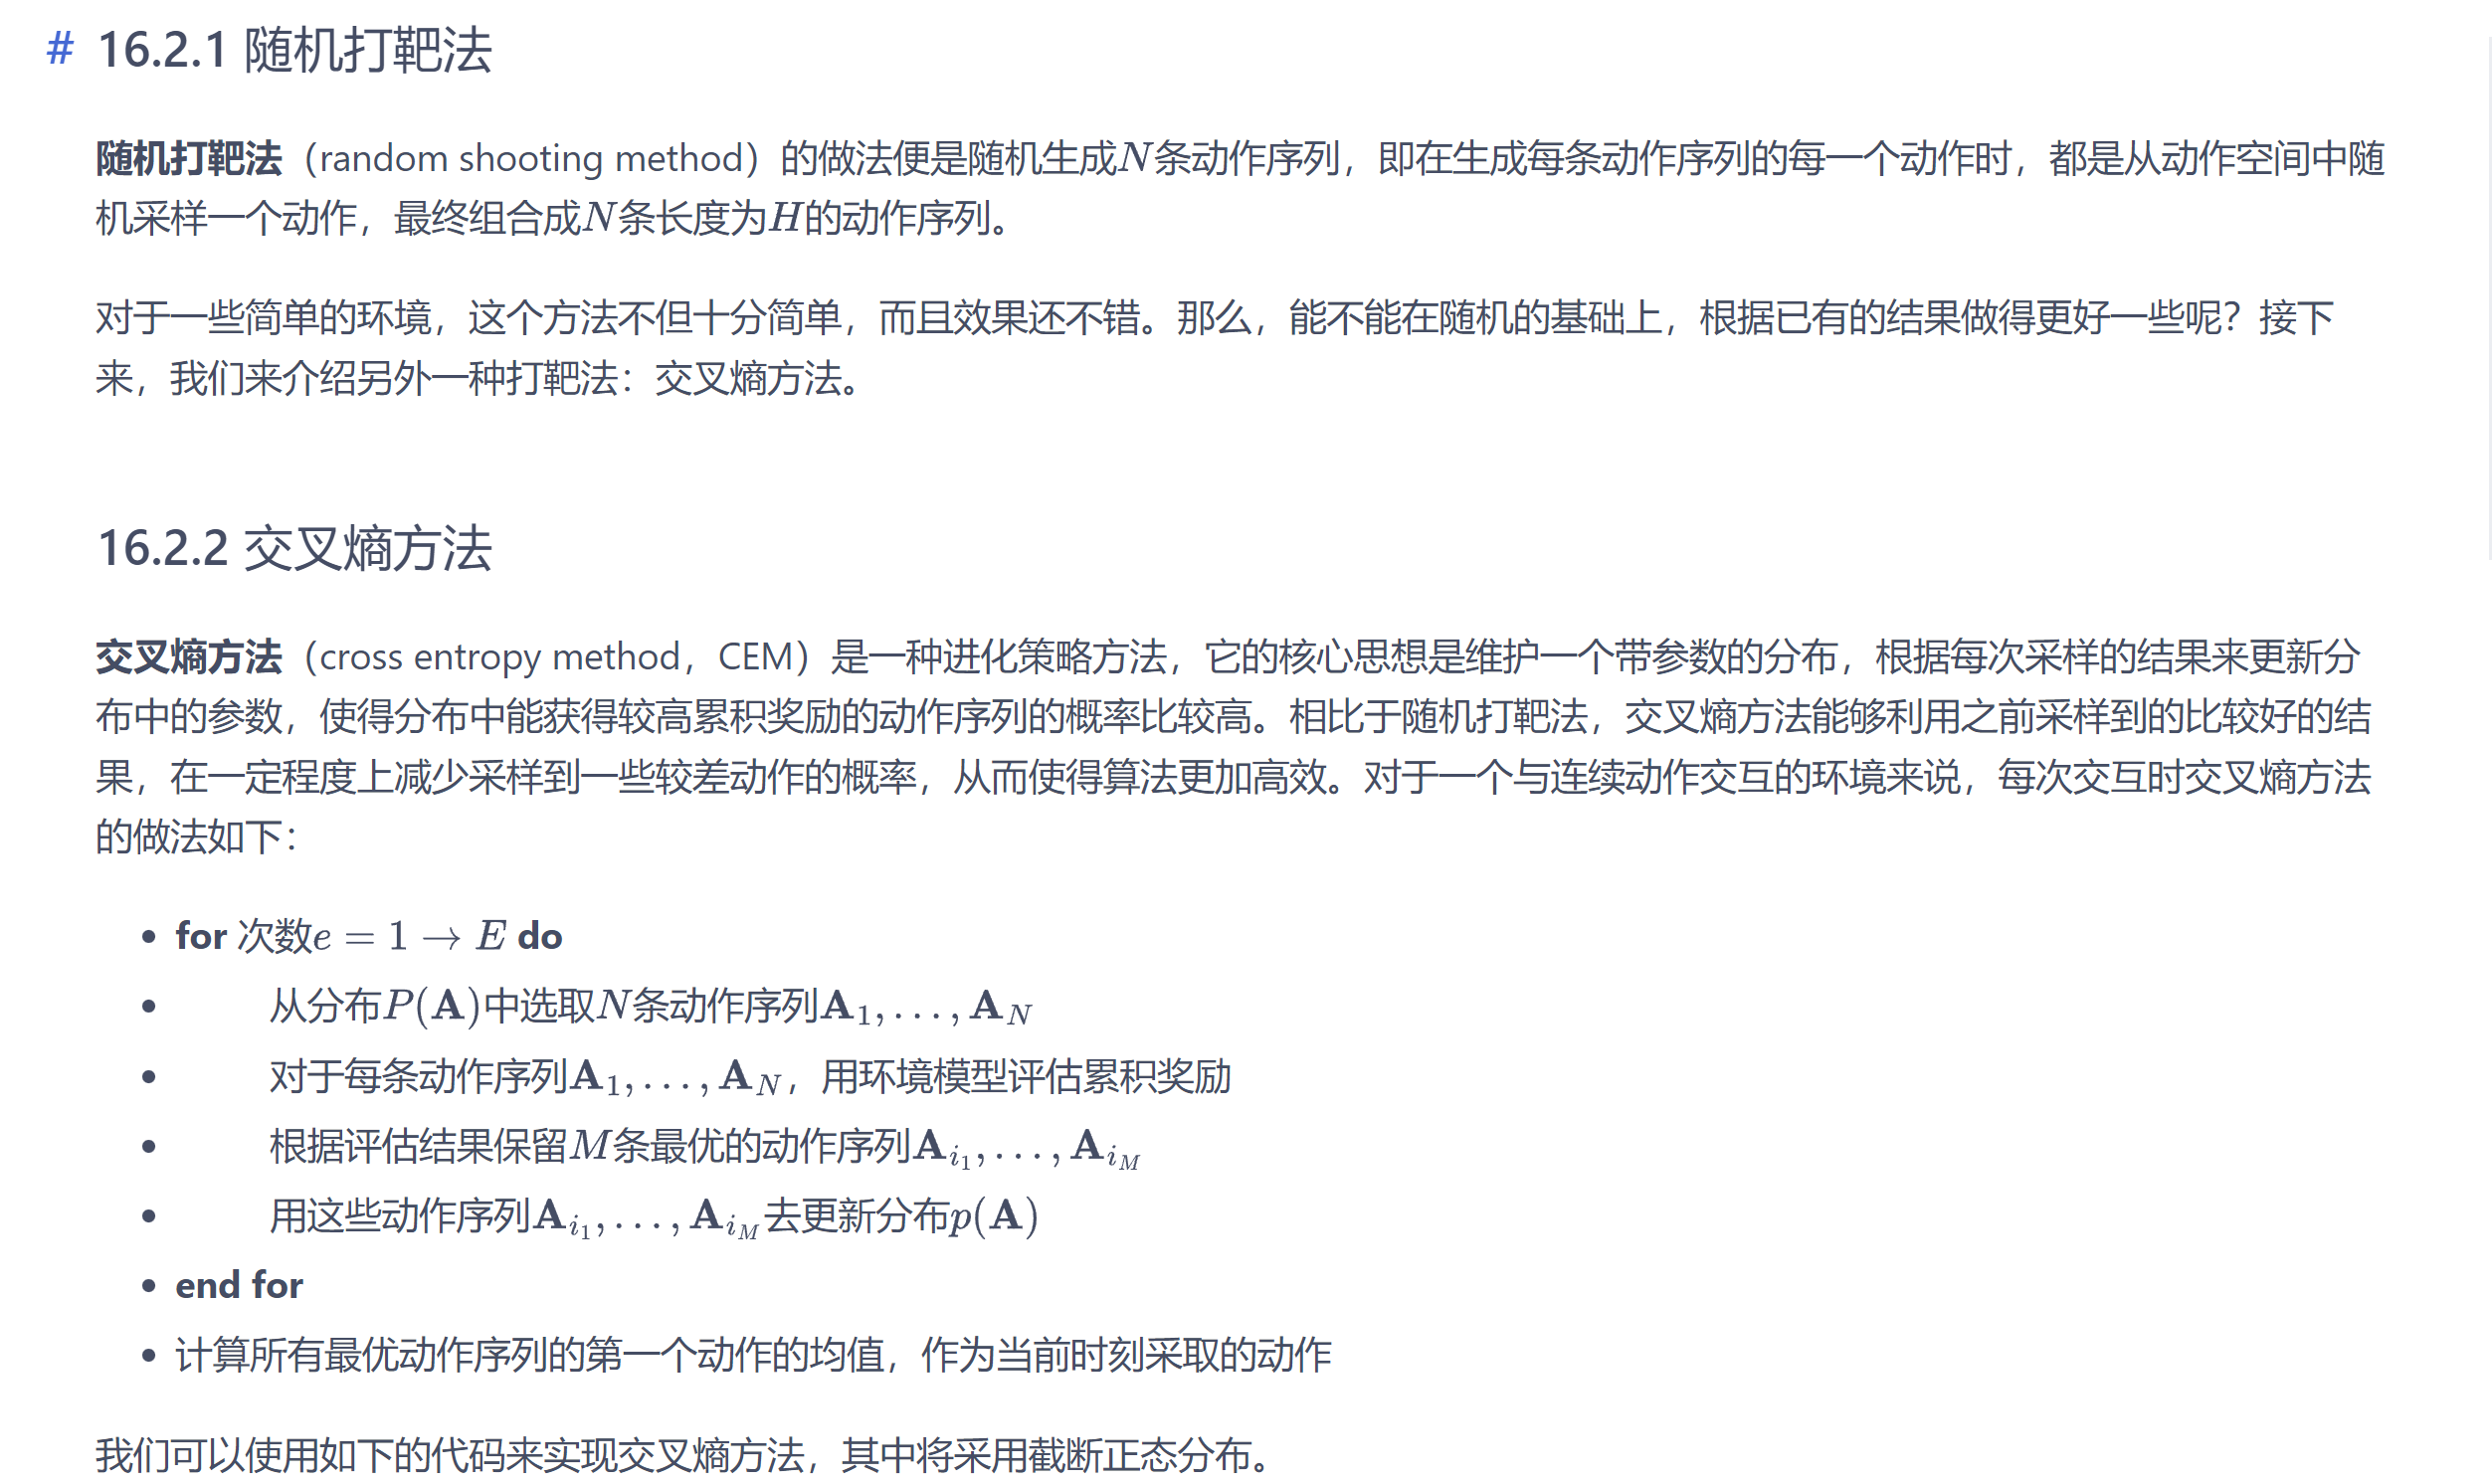
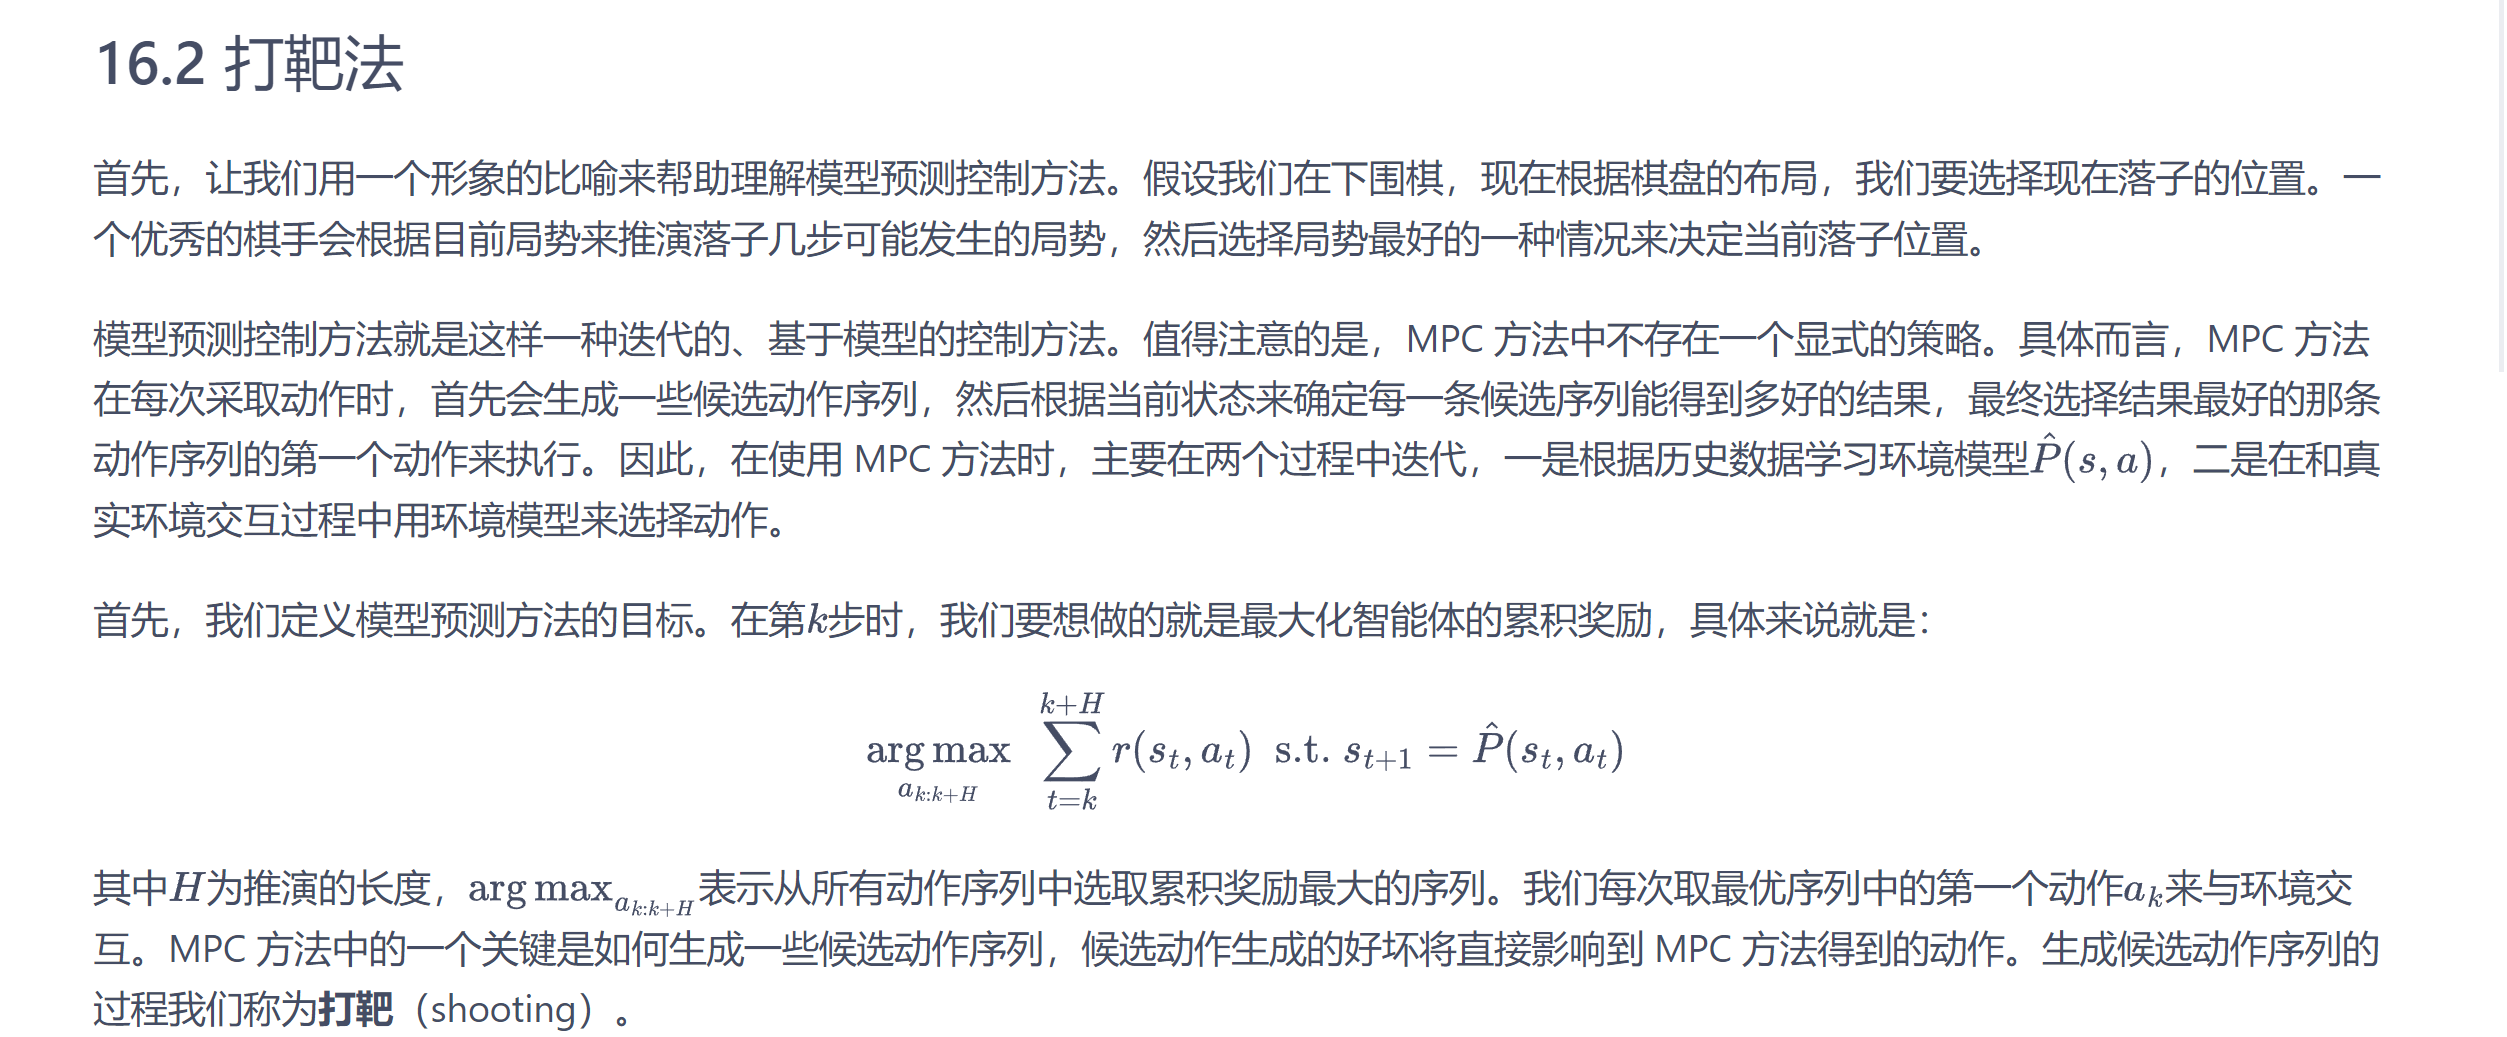

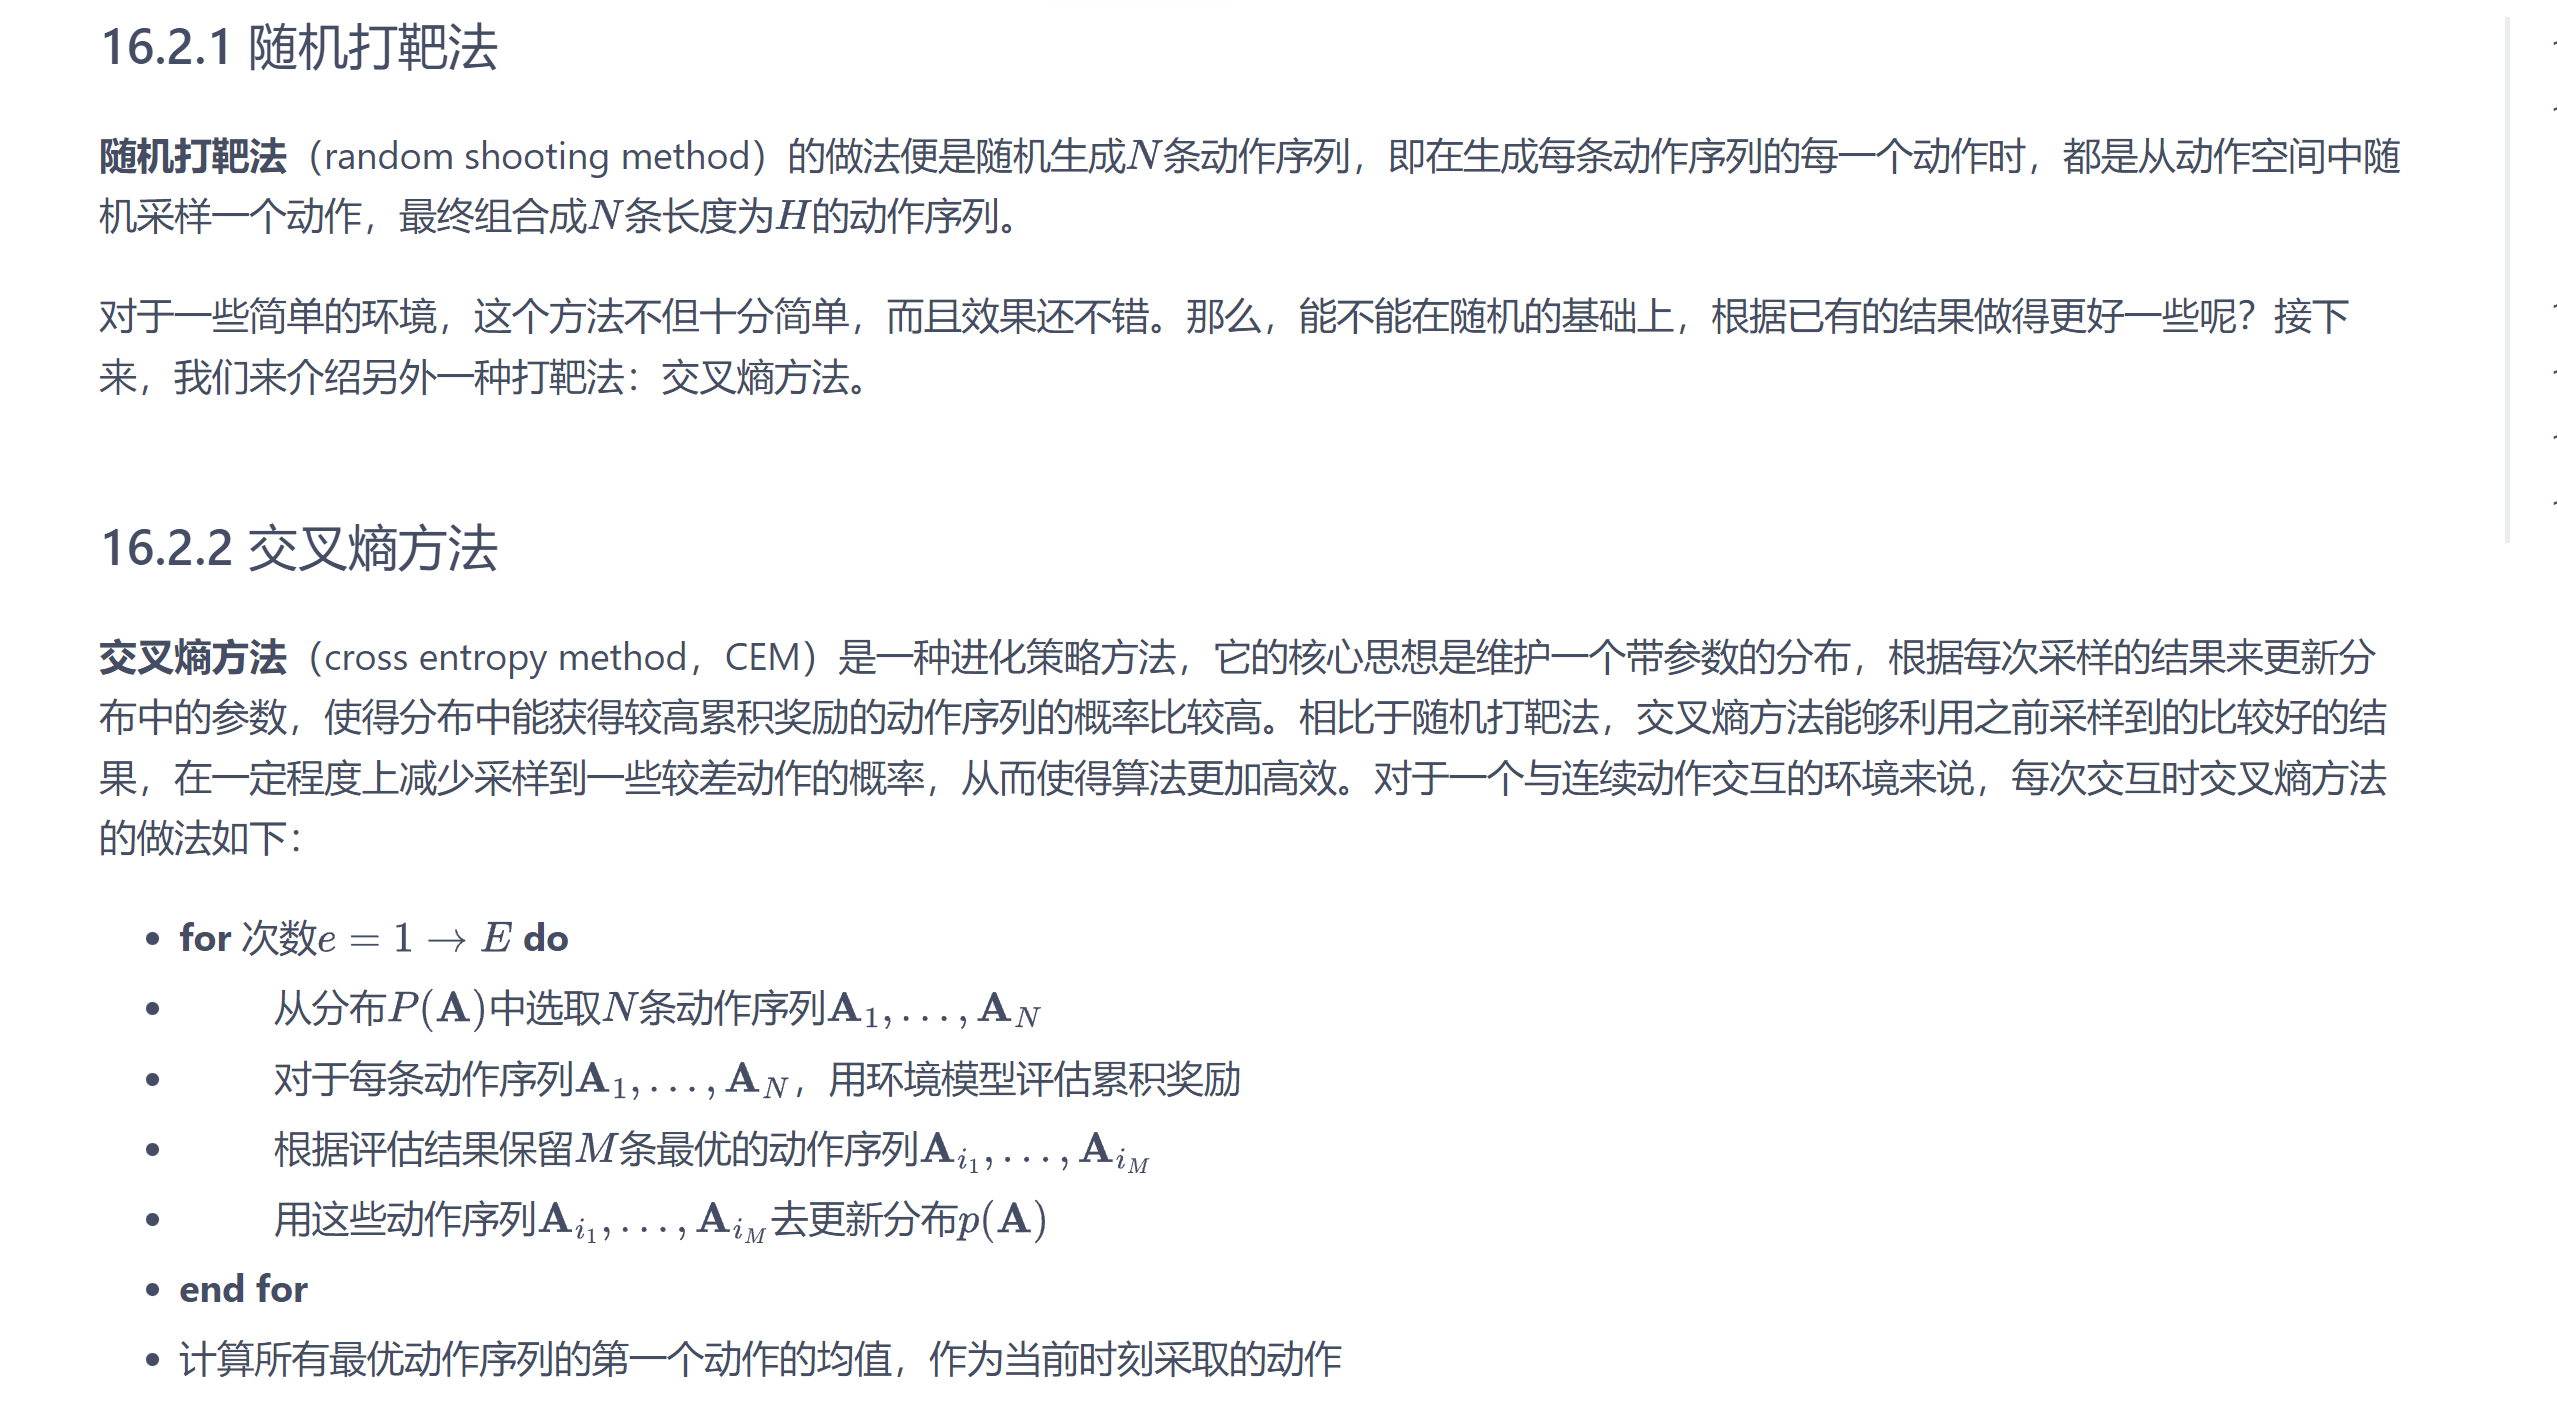


带有轨迹采样的概率集成（probabilistic ensembles with trajectory sampling，PETS）是一种使用 MPC 的基于模型的强化学习算法。在 PETS 中，环境模型采用了集成学习的方法，即会构建多个环境模型，然后用这多个环境模型来进行预测，最后使用 CEM (Cross Entropy Method) 进行模型预测控制。接下来，我们来详细介绍模型构建与模型预测的方法。

PETS相对于以前的概率MBRL算法的一个优势是能够分离两类不同的不确定性：偶然不确定性（固有的系统随机性）和认知不确定性（由于有限的数据导致的主观不确定性）。 

在强化学习中，与智能体交互的环境是一个动态系统，所以拟合它的环境模型也通常是一个动态模型。我们通常认为一个系统中有两种不确定性，分别是:
1. 偶然不确定性（aleatoric uncertainty）,偶然不确定性是由于系统中本身存在的随机性引起的。(e.g. observation noise and process noise). 偶然不确定性可以通过输出参数化分布的参数来捕获，同时仍然有区别地(discriminatively)训练网络。 
2. 认知不确定性（epistemic uncertainty），认知不确定性是由“见”过的数据较少导致的自身认知的不足而引起的.

we describe how we use combinations of **‘probabilistic networks’ to capture aleatoric uncertainty** and **‘ensembles’ to capture epistemic uncertainty**.

在 PET 算法中，环境模型的构建会同时考虑到这两种不确定性。首先，我们定义环境模型的输出为一个高斯分布，用来捕捉偶然不确定性。令环境模型为$\hat P$，其参数为$\theta$，那么基于当前状态动作对$(s_t, a_t)$，下一个状态的分布$s_t$可以写为
$$
\hat{P}\left(s_{t}, a_{t}\right)=\mathcal{N}\left(\mu_{\theta}\left(s_{t}, a_{t}\right), \Sigma_{\theta}\left(s_{t}, a_{t}\right)\right)
$$
这里我们可以采用神经网络来构建$\mu_\theta$和$\Sigma_\theta$。这样，神经网络的损失函数则为
$$
\mathcal{L}(\theta)=\sum_{n=1}^{N}\left[\mu_{\theta}\left(s_{n}, a_{n}\right)-s_{n+1}\right]^{T} \Sigma_{\theta}^{-1}\left(s_{n}, a_{n}\right)\left[\mu_{\theta}\left(s_{n}, a_{n}\right)-s_{n+1}\right]+\log \operatorname{det} \Sigma_{\theta}\left(s_{n}, a_{n}\right)
$$
这样我们就得到了一个由神经网络表示的环境模型。

[多元高斯分布完全解析](https://zhuanlan.zhihu.com/p/58987388)
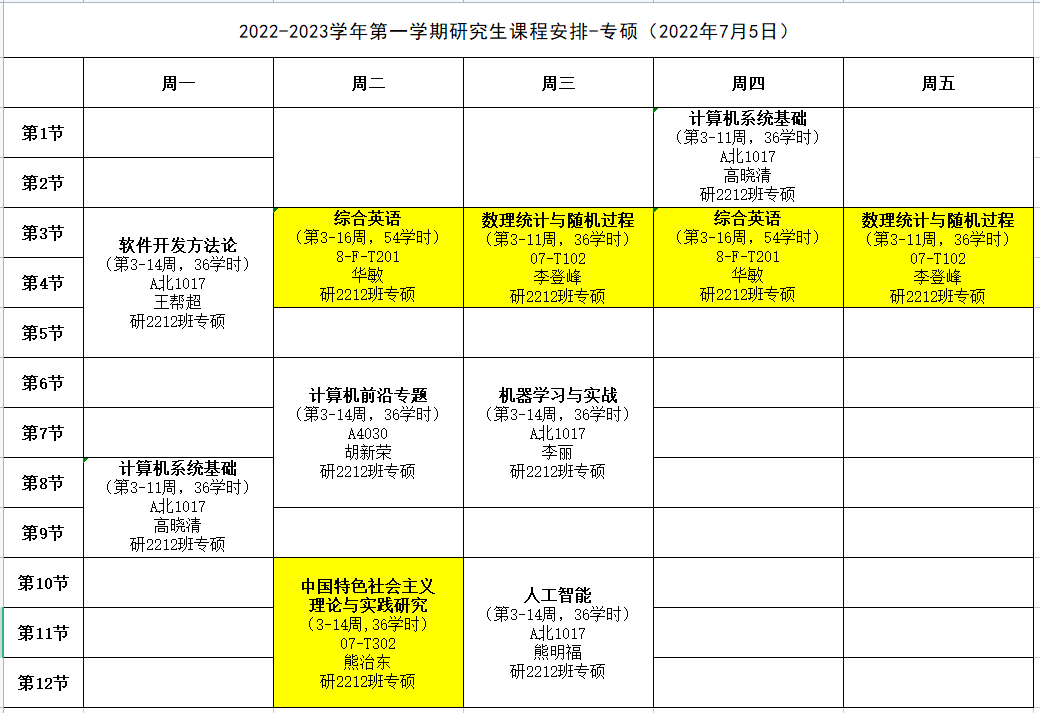

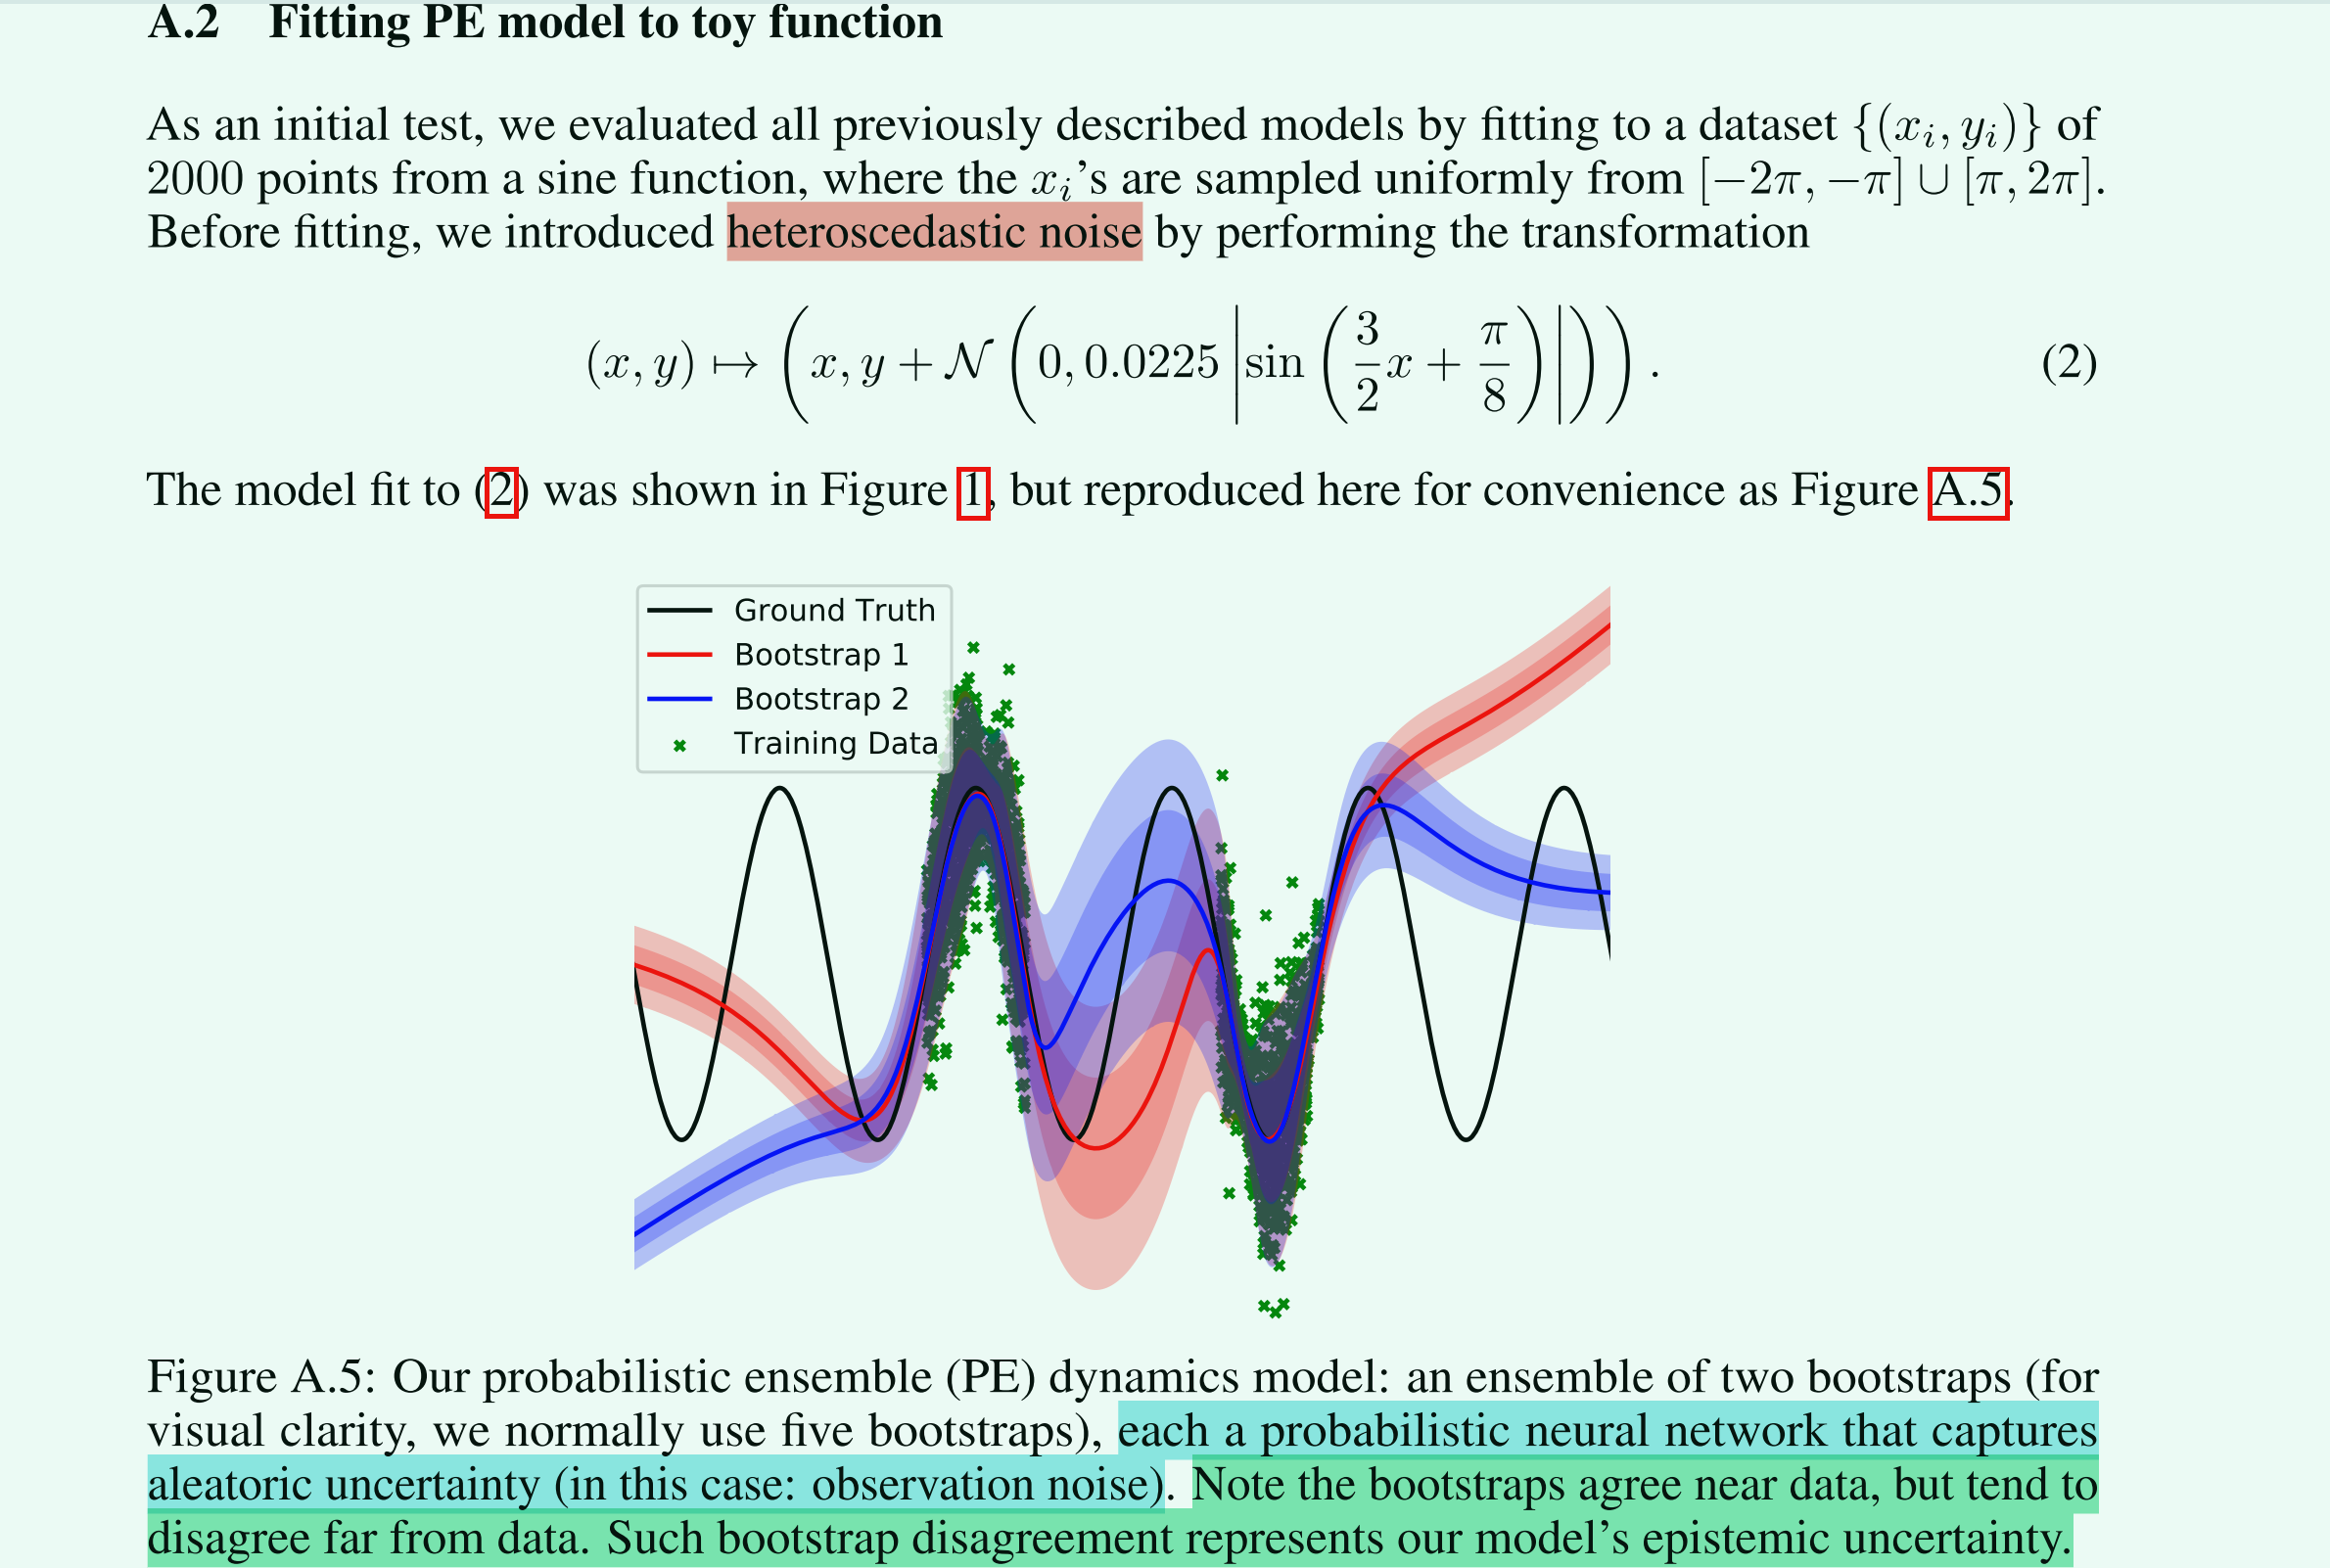

集成(ensemble)就是多个模型取期望,以实现样本复用,用较小的样本实现消除认知不确定性.

> Q. 什么是 Bayesian inference?

> Q. 什么是Moment matching?

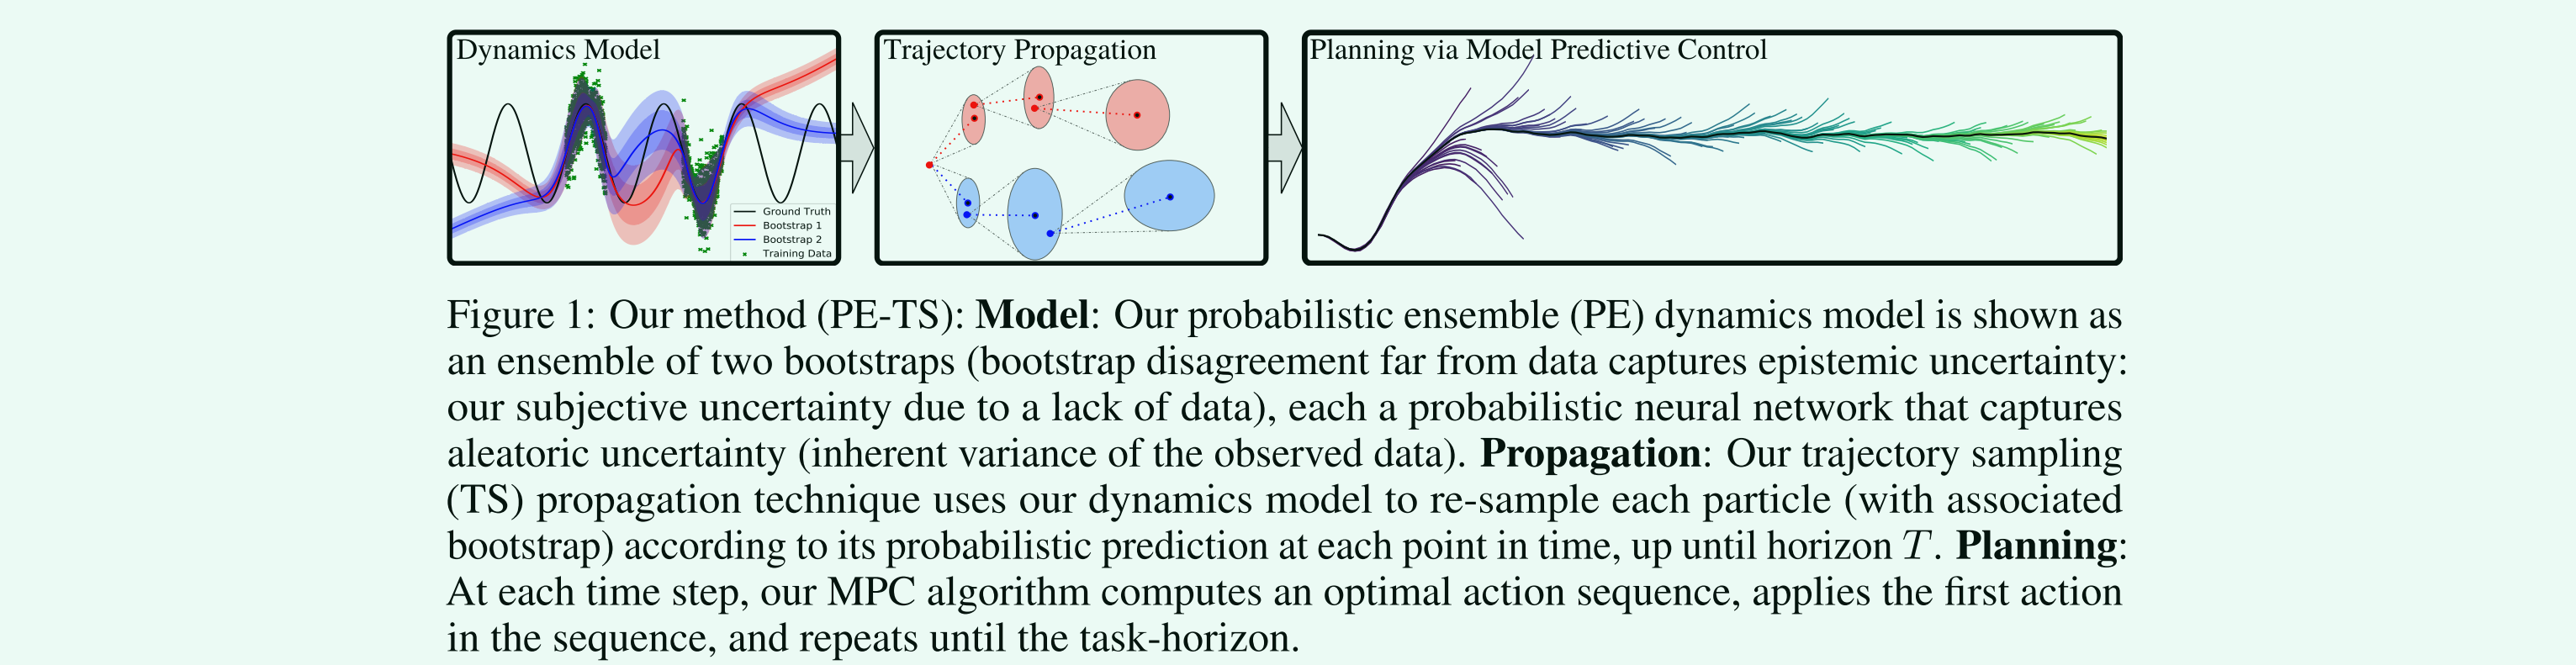

## Uncertainty-aware neural network dynamics models

任何MBRL算法都必须选择一类模型进行动力学预测。 对于MBRL算法来说，这种选择往往是至关重要的，因为即使是很小的偏差也会显著地影响相应控制器的质量 

> Q: 什么是ensemble?
> 

| 1 | 2 | 3 |
|---|---|---|
|23 | 456 | 168 |

---

根据训练方法的不同，model based RL主要可以分为四种方法：
1. [Dyna-style methods], Dyna类的方法的特点是可以将Model free的方法和world model结合，world model可以提供大量的模拟数据给model free的算法进行对policy的学习，属于一种显式的策略训练方法；
2. [Analytical gradient], Analytical类的方法的特点是利用了模型产生数据的可微性（differentiability），直接对trajectory的return进行优化来对策略进行训练；
3. [Planning], Planning类的方法是不显式的对策略进行训练，而是基于world model用简单的规划方法得到一系列动作，能够快速的迁移到相似的任务场景上；
4. [Model-based value expansion], 通过对动作价值或者状态价值更好的估计来减小world model和真实环境中的误差，能够控制模型的使用来平衡偏差和方差。

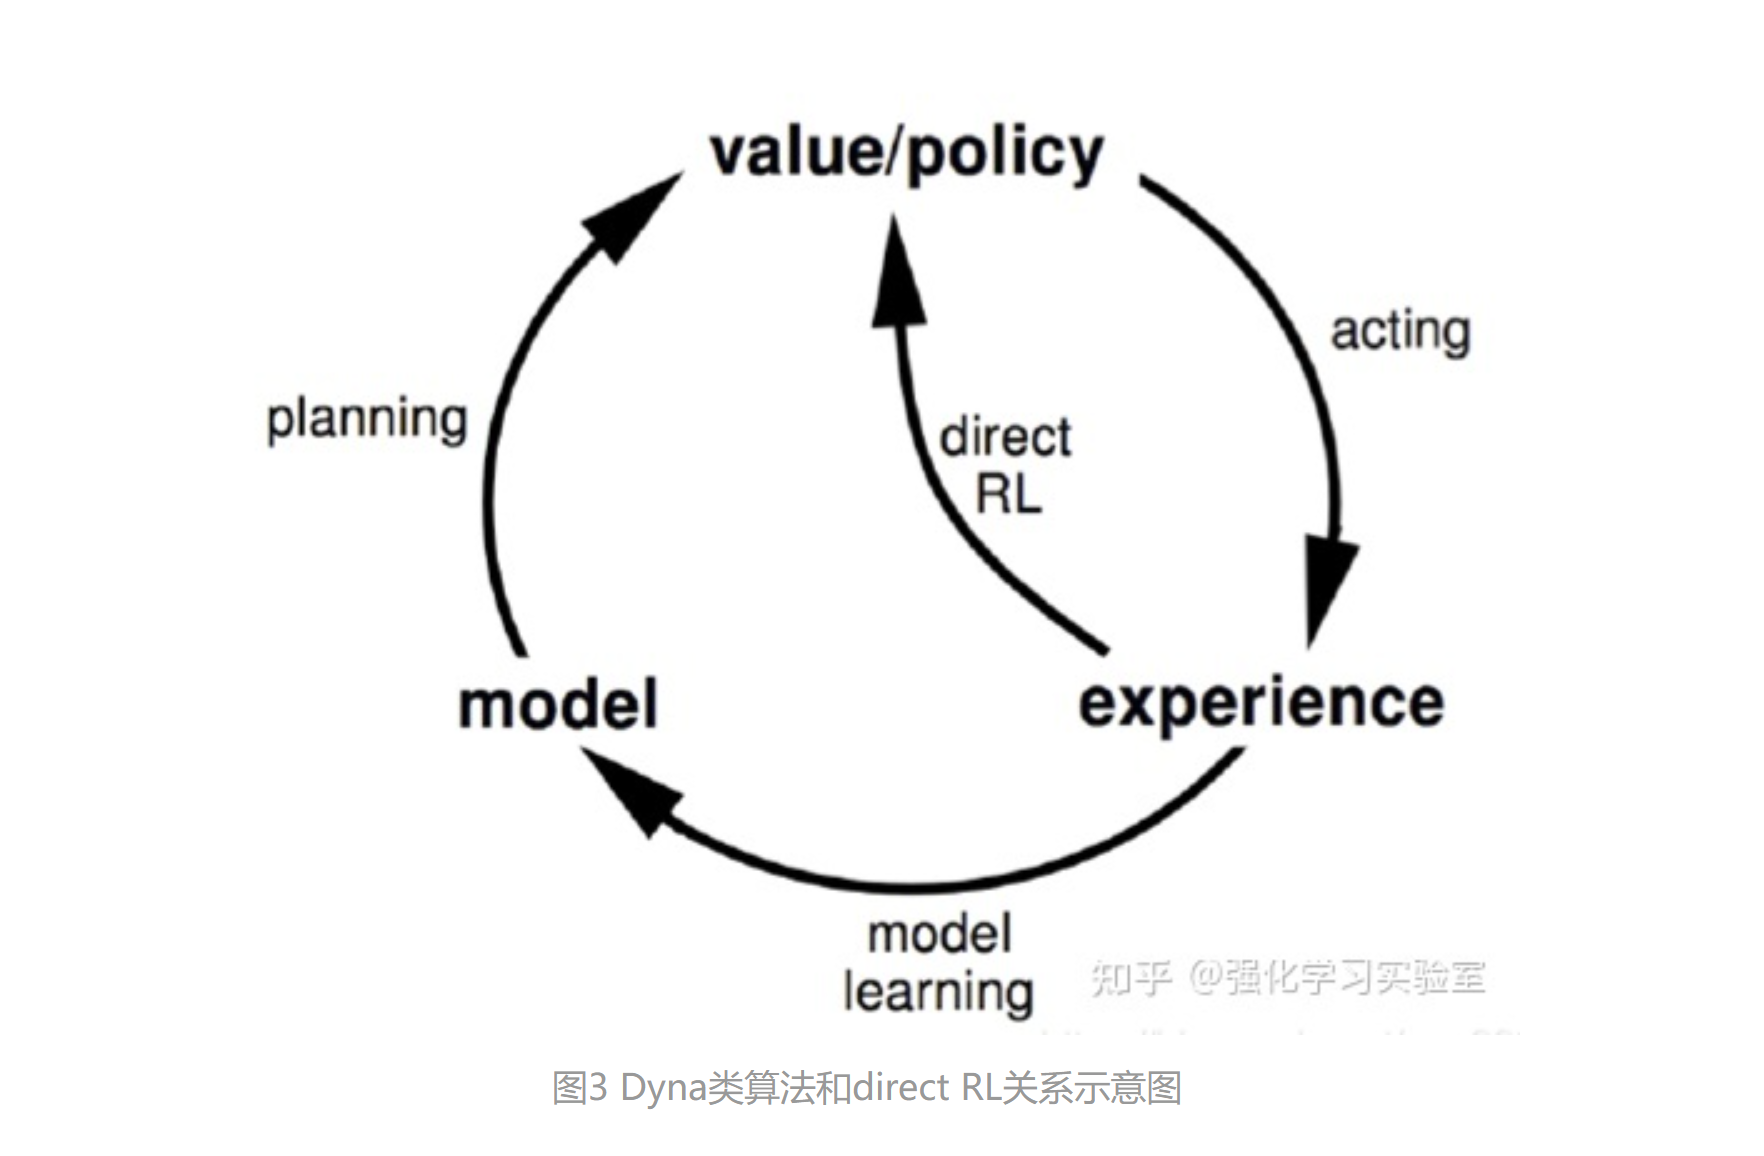